In [1]:
import torch
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
import numpy as np


In [2]:
DEVICE = torch.device('cuda') # cuda
shuffle=True
batch_size = 32

In [3]:
# Loading dataset

loader = METRLADatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio = 0.8)
train_dataset, val_dataset = temporal_signal_split(train_dataset, train_ratio=0.8)

In [4]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [5]:
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from tqdm import tqdm

In [6]:
print("Cuda Available?: ", torch.cuda.is_available())
print("Current Device: ", torch.cuda.get_device_name(torch.cuda.current_device()))

Cuda Available?:  True
Current Device:  NVIDIA GeForce GTX 1060 with Max-Q Design


In [7]:
# for batches
#https://github.com/benedekrozemberczki/pytorch_geometric_temporal/blob/master/examples/recurrent/a3tgcn2_example.py
train_input = np.array(train_dataset.features) # (27399, 207, 2, 12)
train_target = np.array(train_dataset.targets) # (27399, 207, 12)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

val_input = np.array(val_dataset.features) # (27399, 207, 2, 12)
val_target = np.array(val_dataset.targets) # (27399, 207, 12)
val_x_tensor = torch.from_numpy(val_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
val_target_tensor = torch.from_numpy(val_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
val_dataset_new = torch.utils.data.TensorDataset(val_x_tensor, val_target_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

test_input = np.array(test_dataset.features) # (, 207, 2, 12)
test_target = np.array(test_dataset.targets) # (, 207, 12)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [8]:
class dcrnnEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, k, num_cells):
        super(dcrnnEncoder, self).__init__()
        #self.recurrent = DCRNN(node_features, 64, 3)
        self.cells = nn.ModuleList()
        self.cells.append(DCRNN(in_channels, out_channels,k))
        for i in range(num_cells-1):
            self.cells.append(DCRNN(out_channels, out_channels,k))
        #self.linear = torch.nn.Linear(64, 12)

    # x needs to be 207 x 12
    def forward(self, x, edge_index, edge_weight):
        # x is B, N, F, T
        #x = x.permute(0,1,3,2)
        # x is B, N, T, F
        #print('x_in shape: ', x_in.shape)
        # get just speed
        #x = x[:,:,:,0]
        #reshape to (B*N, T)
        hiddens = []
        for i, l in enumerate(self.cells):
            #print(i,": ", x.shape)
            x = l(x, edge_index, edge_weight)
            hiddens.append(x)
            x = F.relu(x)
        return x, hiddens

In [9]:
class dcrnnDecoder(torch.nn.Module):
    def __init__(self, in_channels, hid_channels, out_channels, k, num_cells):
        super(dcrnnDecoder, self).__init__()
        #self.recurrent = DCRNN(node_features, 64, 3)
        self.cells = nn.ModuleList()
        self.cells.append(DCRNN(in_channels, hid_channels,k))
        for i in range(num_cells-1):
            self.cells.append(DCRNN(hid_channels, hid_channels,k))
        self.linear = torch.nn.Linear(hid_channels, out_channels)

    # x needs to be 207 x 12
    def forward(self, x, edge_index, edge_weight, hidden_states):
        # x is B, N, F, T
        #x = x.permute(0,1,3,2)
        # x is B, N, T, F
        #print('x_in shape: ', x_in.shape)
        # get just speed
        # x = x[:,:,:,0]
        #reshape to (B*N, T)
        hiddens = []
        for i, l in enumerate(self.cells):
            #print(i,": ", x.shape)
            x = l(x, edge_index, edge_weight, hidden_states[i])
            hiddens.append(x)
            x = F.relu(x)
        x = self.linear(x)
        return x, hiddens

In [10]:
#https://github.com/benedekrozemberczki/pytorch_geometric_temporal/blob/master/examples/recurrent/dcrnn_example.py
import traceback
class RecurrentGCN(torch.nn.Module):
    def __init__(self, in_feats, out_feats, hidden_feats, num_cells, k, seq_len):
        super(RecurrentGCN, self).__init__()
        self.seq_len = seq_len
        self.encoder = dcrnnEncoder(in_feats, hidden_feats, k, num_cells)
        self.decoder = dcrnnDecoder(in_feats, hidden_feats, out_feats, k, num_cells)
        

    # x needs to be 207 x 12
    def forward(self, x, edge_index, edge_weight):
        # x is B, N, F, T
        x = x.permute(3,0,1,2)
        # x is T, B, N, F, 
        #print('x_in shape: ', x_in.shape)
        # get just speed
        #x = x[:,:,:,0]
        #reshape to (T, B*N, F)
        x = x.reshape((x.shape[0], x.shape[1]*x.shape[2], x.shape[3]))
        for i in range(self.seq_len):
            #print("in shape: ", x[i].shape)
            #print("edge idx: ", edge_index.shape)
            #print("edge_weight", edge_weight.shape)
            try:
                encode_out, encode_states = self.encoder(x[i], edge_index, edge_weight)
            except:
                traceback.print_exc()
        outputs = []
        for i in range(self.seq_len):  
            decode_out, decode_states = self.decoder(x[i], edge_index, edge_weight, encode_states)
            outputs.append(decode_out)
        outputs = torch.stack(outputs).cuda()
        return outputs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

model = RecurrentGCN(in_feats=2, out_feats=1, hidden_feats = 64, num_cells=2, k=3, seq_len=12)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_decay_ratio=0.1

steps = [20,30,40,50,60,70,80,90]

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=steps, gamma=lr_decay_ratio)

#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=lr_decay_ratio)

loss_fn = torch.nn.MSELoss()
loss_fn2 = F.l1_loss

In [15]:
# Loading the graph once because it's a static graph
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    static_edge_attr = snapshot.edge_attr.to(DEVICE)
    break

# Training the model 
model.train()

epoch_vals = []
epoch_trains = []
for epoch in range(100):
    step = 0
    loss_list = []
    val_loss_list = []
    for encoder_inputs, labels in train_loader:
        # if encoder_inputs.shape[0] != batch_size:
        #     print("ERROR IN SHAPE:", encoder_inputs.shape)
        # else:
        #     print(encoder_inputs.shape)
        y_hat = model(encoder_inputs, static_edge_index, static_edge_attr)         # Get model predictions
        #print(y_hat.shape)
        #print(labels.shape)
        # yhat is T, B*N, 1
        y_hat = y_hat.permute(1, 2, 0)
        # reshape back to BxNxT
        #print(y_hat.shape)
        y_hat = y_hat.reshape((labels.shape))
        #print("y hat:" , y_hat.shape, " labels: ", labels.shape)
        mean = [53.59967, 0.4982691]
        std = [20.209862, 0.28815305]
        labels = labels*std[0] + mean[0]
        y_hat = y_hat*std[0] + mean[0]
        loss = loss_fn2(y_hat, labels) 
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step= step+ 1
        #loss = torch.sqrt(loss)
        loss_list.append(loss.item())
        if step % 100 == 0 :
            print("    train MAE: ", sum(loss_list)/len(loss_list))
    lr_scheduler.step()
    train_MAE = sum(loss_list)/len(loss_list)
    epoch_trains.append(train_MAE)
    print("Epoch {} train MAE: {:.4f}".format(epoch, train_MAE))

    model.eval()

    for encoder_inputs, labels in val_loader:
        y_hat = model(encoder_inputs, static_edge_index, static_edge_attr)         # Get model predictions
        #print(y_hat.shape)
        #print(labels.shape)
        # yhat is T, B*N, 1
        y_hat = y_hat.permute(1, 2, 0)
        # reshape back to BxNxT
        #print(y_hat.shape)
        y_hat = y_hat.reshape((labels.shape))
        mean = [53.59967, 0.4982691]
        std = [20.209862, 0.28815305]
        labels = labels*std[0] + mean[0]
        y_hat = y_hat*std[0] + mean[0]
        loss = loss_fn2(y_hat, labels) 
        val_loss_list.append(loss.item())
        #if step % 100 == 0 :
        #    print("    train MAE: ", sum(loss_list)/len(loss_list))
    val_MAE = sum(val_loss_list)/len(val_loss_list)
    epoch_vals.append(val_MAE)
    print("Epoch {} val MAE: {:.4f}".format(epoch, val_MAE))
  

## Evaluation

#- Lets get some sample predictions for a specific horizon (e.g. 288/12 = 24 hours)
#- The model always gets one hour and needs to predict the next hour

model.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index, static_edge_attr)
    #print(y_hat.shape)
    #print(labels.shape)
    # yhat is T, B*N, 1
    y_hat = y_hat.permute(1, 2, 0)
    # reshape back to BxNxT
    #print(y_hat.shape)
    y_hat = y_hat.reshape((labels.shape))
    # undo z-score
    mean = [53.59967, 0.4982691]
    std = [20.209862, 0.28815305]
    labels = labels*std[0] + mean[0]
    y_hat = y_hat*std[0] + mean[0]
    # Mean squared error
    #loss = loss_fn(y_hat, labels)
    # Mean absolute error
    loss = loss_fn2(y_hat, labels)
    total_loss.append(loss.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)
    

print("Test MAE: {:.4f}".format(sum(total_loss)/len(total_loss)))



KeyboardInterrupt: 

In [ ]:
torch.save(model, "dcrnn_4_24")

In [ ]:
print(epoch_vals)
print(epoch_trains)

[4.6181958030251895, 4.696093590119306, 4.563377930136288, 4.583720131481395, 4.531516271478989, 4.7971130258896775, 4.5612548014696905, 4.5089328317081225, 4.593786772559671, 4.577736977969899, 4.519587292390711, 4.506462346806246, 4.482652221006505, 4.524929924572215, 4.549955940246582, 4.4901377397425035, 4.506476724849028, 4.503085823620067, 4.478586592393763, 4.501496084998636, 4.4369101608500765, 4.433597758237053, 4.43433217160842, 4.447387476528392, 4.430844865125768, 4.428740229326136, 4.436907142751357, 4.435491536645328, 4.430200357998118, 4.437904890845804, 4.433229785806993, 4.407254996019251, 4.432292189317591, 4.40745935159571, 4.42586550432093, 4.424384274202235, 4.416888598834767, 4.423895462821512, 4.429526881610646, 4.425868791692397, 4.417733066222247, 4.429021080802468, 4.42190858336056, 4.423879006329705, 4.428090855654548, 4.42579636293299, 4.422193485147813, 4.419559551687802, 4.410024539162131, 4.424417316212374, 4.423856090096867, 4.422612754036399, 4.42787849

In [ ]:
#%pip install matplotlib
import matplotlib.pyplot as plt

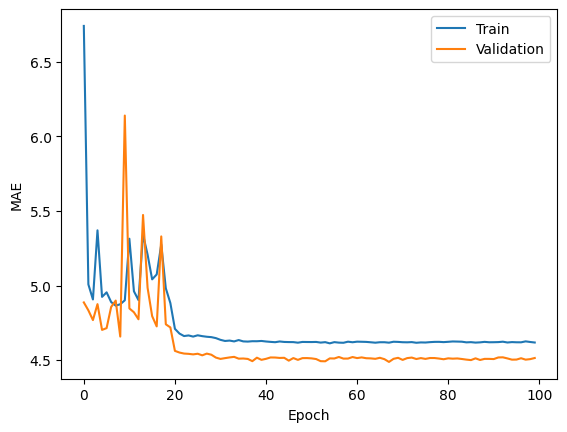

In [ ]:
plt.plot(epoch_trains, label = 'Train')
plt.plot(epoch_vals, label = 'Validation')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.show()



In [ ]:
# no batching
# model.train()

# for epoch in tqdm(range(10)):
#     cost = 0
#     for time, snapshot in enumerate(train_dataset):
#         if(time == 0):
#             edge_idx = snapshot.edge_index.to(device)
#             edge_attr = snapshot.edge_attr.to(device)
#         x_in = snapshot.x.permute(0,2,1)
#         #print('x_in shape: ', x_in.shape)
#         x_in = x_in[:,:,0]
#         x_in = x_in.reshape((x_in.shape[0], x_in.shape[1]))
#         n,f,t = snapshot.x.shape  # n = num nodes, f = num features, t = num timesteps
        
#         #x_in = snapshot.x.reshape((t, n*f))
#         #print('new x_in shape: ', x_in.shape)
#         x_in = x_in.to(device)
        
#         y_hat = model(x_in, edge_idx, edge_attr)
#         y = snapshot.y.to(device)
#         cost = cost + torch.mean((y_hat-y)**2)
#         #print("y_hat shape: ", y_hat.shape)
#         #print("y shape: ", y.shape)
#         #print(time)
#     cost = cost / (time+1)
#     cost.backward()
#     optimizer.step()
#     optimizer.zero_grad()
    
# model.eval()
# cost = 0
# for time, snapshot in enumerate(test_dataset):
#     x_in = snapshot.x.permute(0,2,1)
#     #print('x_in shape: ', x_in.shape)
#     x_in = x_in[:,:,0]
#     x_in = x_in.reshape((x_in.shape[0], x_in.shape[1]))
#     x_in = x_in.to(device)
#     edge_idx = snapshot.edge_index.to(device)
#     edge_attr = snapshot.edge_attr.to(device)
#     y_hat = model(x_in, edge_idx, edge_attr)
#     y = snapshot.y.to(device)
#     #print("y_hat shape: ", y_hat.shape)
#     #print("y shape: ", y.shape)
#     cost = cost + torch.mean((y_hat-y)**2)
# cost = cost / (time+1)
# cost = cost.item()
# print("MSE: {:.4f}".format(cost))